In [277]:
import numpy as np
import matplotlib.pyplot as plt
import nnpy.Izhtools as it
import nnpy.visu_tools as visu

## two cell interaction  
Test, exc-exc cell

In [344]:
color_codes = ['#C62828', '#1565C0']

def draw_spk(**kwargs):
    for i in range(2):
        for t in obj2.t_spks[i]:
            plt.plot([t, t], yl, c=color_codes[i], **kwargs)

In [345]:
obj2 = it.Reader("../data/two_cell_ntk")
obj2.read_uv()
obj2.read_ic()
obj2.read_r()
obj2.read_tspk()

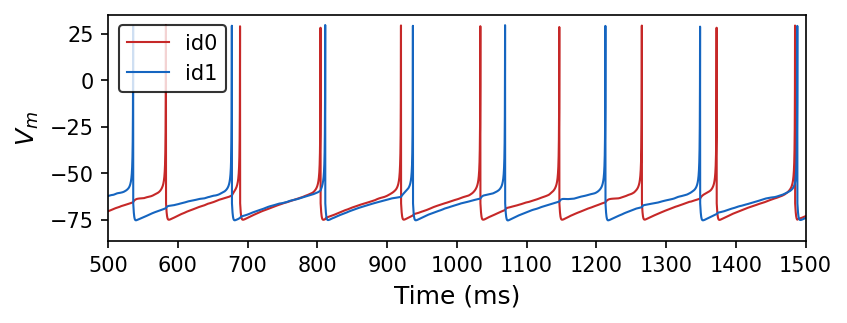

In [346]:
plt.figure(dpi=150, figsize=(6, 2))
for i in range(2):
    plt.plot(obj2.ts, obj2.vs[:, i], lw=1, c=color_codes[i], label='id%d'%(i))
plt.legend(fontsize=10, edgecolor='k')
plt.xlim([500, 1500])
plt.xticks(np.arange(500, 1600, 100))
plt.xlabel(r"Time (ms)", fontsize=12)
plt.ylabel(r"$V_{m}$", fontsize=12)
plt.show()

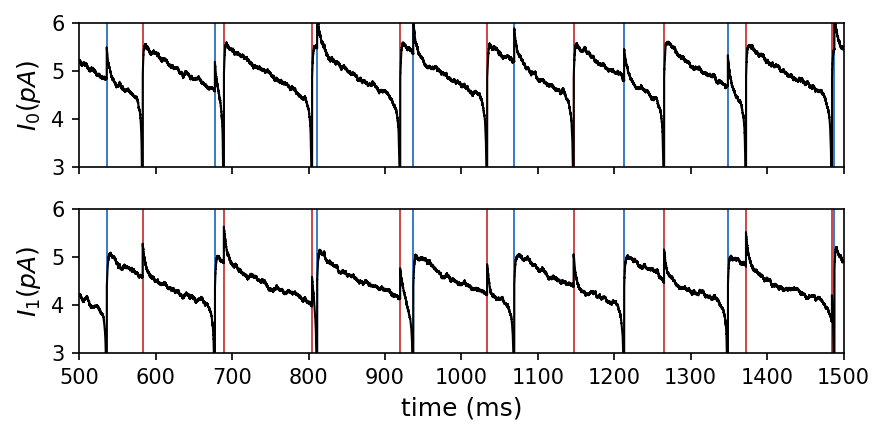

In [347]:
xl = [500, 1500]
yl = [3, 6]

plt.figure(dpi=150, figsize=(6, 3))
for n in range(2):
    plt.subplot(2,1,n+1)
    
    draw_spk(lw=0.8)

    plt.plot(obj2.ts, obj2.ics[:, n], lw=1, c='k')
    plt.xlim(xl)
    plt.ylim(yl)
    
    if n == 0:
        plt.xticks(np.arange(500, 1600, 100), labels=[])
    else:
        plt.xticks(np.arange(500, 1600, 100))
    plt.ylabel(r"$I_{%d} (pA)$"%(n), fontsize=12)
        
plt.xlabel("time (ms)", fontsize=12)
        
plt.tight_layout()
plt.show()

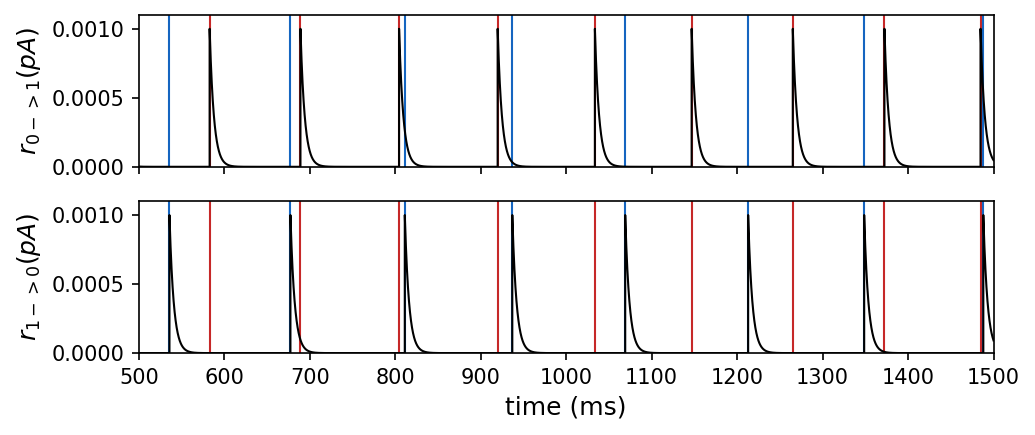

In [348]:
xl = [500, 1500]
yl = [0, 0.0011]

plt.figure(dpi=150, figsize=(7, 3))
for n in range(2):
    plt.subplot(2,1,n+1)
    
    draw_spk(lw=1)
    plt.plot(obj2.ts, obj2.rs[:, n], lw=1, c='k')
    plt.xlim(xl)
    plt.ylim(yl)
    
    if n == 0:
        plt.xticks(np.arange(500, 1600, 100), labels=[])
    else:
        plt.xticks(np.arange(500, 1600, 100))
    plt.ylabel(r"$r_{%d->%d} (pA)$"%(n, 1-n), fontsize=12)
    
    yt = plt.gca().get_yticks()
#     plt.yticks(yt, ['%.2e'%(x) for x in yt])
        
plt.xlabel("time (ms)", fontsize=12)
        
plt.tight_layout()
plt.show()

## Multiple cell network

In [453]:
from scipy.ndimage import gaussian_filter1d

def get_xnorm(x, x_avg, x_amp):
    y = (x-min(x)) / (max(x) - min(x)) * 2 - 1
    return y * x_amp + x_avg

def show_itv(t_spks, cell_types, color_codes=None, labels=None, edges=None):
    frs = []
    frs_ctp = []
    for n, t_spk in enumerate(t_spks):
        dt = t_spk[1:] - t_spk[:-1]
        frs.extend(1000/dt)
        for i in range(len(dt)):
            frs_ctp.append(cell_types[n])
            
    if edges is None:
        edges = np.linspace(min(frs), max(frs), 21)
    
    for n in np.unique(frs_ctp):
        tmp_frs = [f for f, tp in zip(frs, frs_ctp) if tp == n]
        
        kwargs = {}
        if color_codes is not None:
            kwargs['color'] = color_codes[n]
        if labels is not None:
            kwargs['label'] = labels[n]
        else:
            kwargs['label'] = 'type%d'%(n)
        
        plt.hist(tmp_frs, edges, edgecolor='k', **kwargs)
    
    return frs, frs_ctp

def get_fft_with_t(x, t, t_range=None):
    if t_range is None:
        t_range = [t[0], t[-1]]
    
    idt = (t >= t_range[0]) & (t < t_range[1])
    N = sum(idt)
    dt = 0.005/1000
    
    freq = np.linspace(0, 1/(2*dt), N//2)
    yf = np.fft.fft(x[idt])
    yf = 2/N * np.abs(yf[:N//2])
    
    return freq, yf

### without current

In [464]:
obj_ntk = it.Reader("../data/single_ntk")
obj_ntk.read_uv()
obj_ntk.read_ic()
obj_ntk.read_tspk()

In [465]:
vm = np.average(obj_ntk.vs[:, np.array(obj_ntk.cell_types)==0], 1)
vm = gaussian_filter1d(vm, 500)

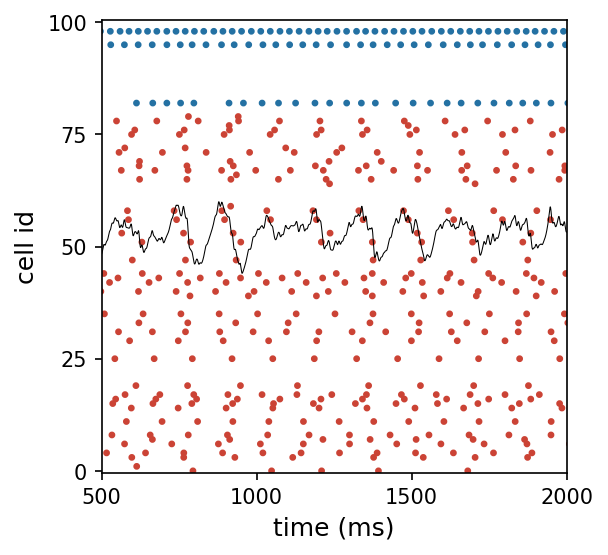

In [484]:
plt.figure(dpi=150, figsize=(4,4))

idt = obj_ntk.ts > 200
plt.plot(obj_ntk.ts[idt], get_xnorm(vm[idt], 50, 10), 'k', lw=0.5, alpha=1)

visu.draw_raster_plot(obj_ntk.t_spks, cell_types=obj_ntk.cell_types, s=5)
plt.xlim([500, 2000])
plt.ylim([-0.5, obj_ntk.N+0.5])
plt.xticks(np.arange(500, 2100, 500))

yt = np.arange(0, 101, 25)
plt.yticks(yt, ['%d'%(i) for i in yt])
plt.ylabel("cell id", fontsize=12)
plt.show()

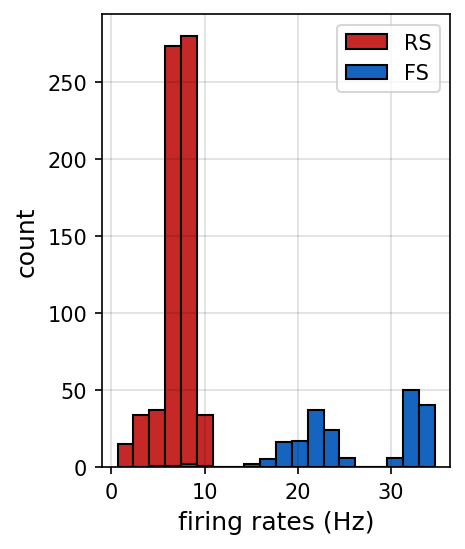

In [468]:
plt.figure(dpi=150, figsize=(3, 4))
frs, ctp = show_itv(obj_ntk.t_spks, obj_ntk.cell_types, color_codes=color_codes, labels=['RS', 'FS'])

plt.legend(fontsize=10)
plt.xlabel("firing rates (Hz)", fontsize=12)
plt.ylabel("count", fontsize=12)
plt.grid(True, lw=0.1, c='k')
plt.show()

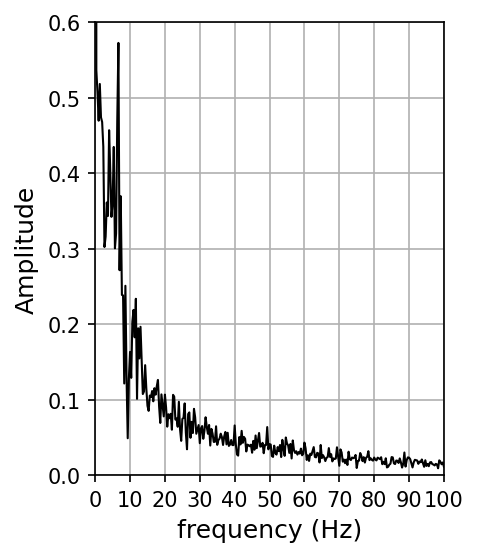

In [483]:
f, yf = get_fft_with_t(vm, obj_ntk.ts)
xt = np.arange(0, 101, 10)

plt.figure(dpi=150, figsize=(3,4))
plt.plot(f, yf, 'k', lw=1)
plt.xlim([0.5, 100])
plt.ylim([0, 0.6])
plt.xticks(xt)
plt.xlabel("frequency (Hz)", fontsize=12)
plt.ylabel("Amplitude", fontsize=12)
plt.grid(True)
plt.show()

### with current

In [497]:
obj_ntk_c = it.Reader("../data/single_ntk_c")
obj_ntk_c.read_uv()
obj_ntk_c.read_ic()
obj_ntk_c.read_tspk()

In [498]:
vm = np.average(obj_ntk_c.vs[:, np.array(obj_ntk_c.cell_types)==0], 1)
vm = gaussian_filter1d(vm, 500)

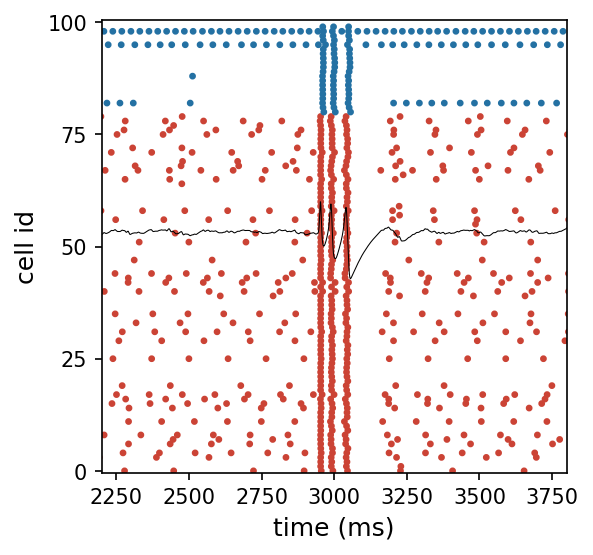

In [505]:
plt.figure(dpi=150, figsize=(4,4))

plt.plot(obj_ntk_c.ts, get_xnorm(vm, 50, 10), 'k', lw=0.5, alpha=1)
visu.draw_raster_plot(obj_ntk_c.t_spks, cell_types=obj_ntk_c.cell_types, s=5)
plt.xlim([2200, 3800])
plt.ylim([-0.5, obj_ntk_c.N+0.5])

yt = np.arange(0, 101, 25)
plt.yticks(yt, ['%d'%(i) for i in yt])
plt.ylabel("cell id", fontsize=12)
plt.show()

In [551]:
t_range = [[2000, 2900], [3100, 4000]]
lbs = ['t = 2.0-2.9s', 't = 3.1-4.0s']

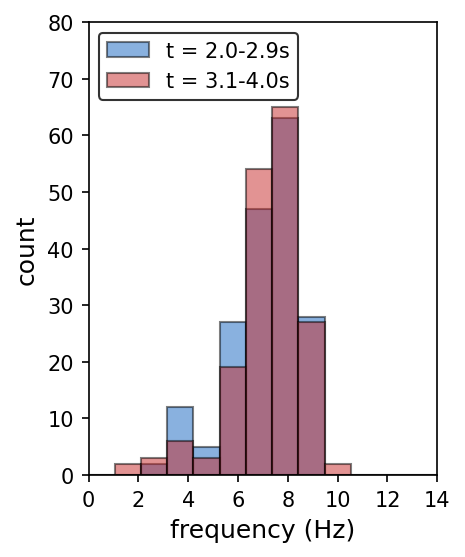

In [556]:
edges = np.linspace(0, 20, 20)

plt.figure(dpi=150, figsize=(3,4))

for i, ts in enumerate(t_range):
    frs = []
    for n, t_spk in enumerate(obj_ntk_c.t_spks[:80]): # exc
        t = t_spk[(t_spk >= ts[0]) * (t_spk <= ts[1])]
        dt = t[1:] - t[:-1]
        frs.extend(1000/dt)
        
    plt.hist(frs, edges, edgecolor='k', color=color_codes[1-i], alpha=0.5, label=lbs[i])
    
plt.xlabel("frequency (Hz)", fontsize=12)
plt.ylabel("count", fontsize=12)
plt.xticks(np.arange(0, 21, 2))
plt.xlim([0, 14])
plt.legend(fontsize=10, edgecolor='k', loc='upper left')
plt.ylim([0, 80])
plt.show()
    

In [ ]:
plt.figure(dpi=150, figsize=(3, 4))
frs, ctp = show_itv(obj_ntk.t_spks, obj_ntk.cell_types, color_codes=color_codes, labels=['RS', 'FS'])

plt.legend(fontsize=10)
plt.xlabel("firing rates (Hz)", fontsize=12)
plt.ylabel("count", fontsize=12)
plt.grid(True, lw=0.1, c='k')
plt.show()

In [509]:
fs, yfs = [], []
for ts in t_range:
    tmp_f, tmp_yf = get_fft_with_t(vm, obj_ntk_c.ts, ts)
    fs.append(tmp_f)
    yfs.append(tmp_yf)

In [ ]:
colors = ['k', '#C62828', '#1565C0']
xt = np.arange(0, 101, 10)

plt.figure(dpi=150, figsize=(3,4))
for i in range(2):
    plt.plot(fs[i], yfs[i], lw=1.5, c=color_codes[1-i], label=lbs[i])
plt.xlim([1, 100])
plt.xticks(xt)
plt.ylim([0, 1])
plt.xlabel("frequency (Hz)", fontsize=12)
plt.ylabel("amplitude", fontsize=12)
plt.grid(True)
plt.legend(edgecolor='k')
plt.show()

## single cell network with current

In [405]:
obj_ntk = it.Reader("../data/single_ntk_c")
obj_ntk.read_uv()
obj_ntk.read_ic()
obj_ntk.read_tspk()

In [406]:
vm = np.average(obj_ntk.vs[:, np.array(obj_ntk.cell_types)==0], 1)

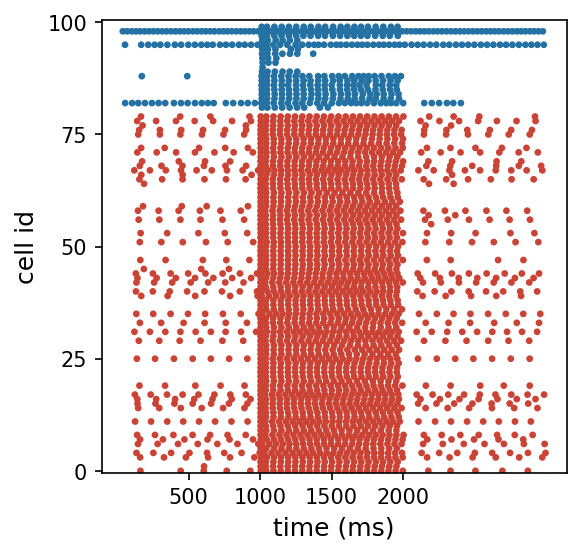

In [407]:
plt.figure(dpi=150, figsize=(4,4))

visu.draw_raster_plot(obj_ntk.t_spks, cell_types=obj_ntk.cell_types, s=5)
# plt.xlim([500, 2000])
plt.ylim([-0.5, obj_ntk.N+0.5])
plt.xticks(np.arange(500, 2100, 500))

yt = np.arange(0, 101, 25)
plt.yticks(yt, ['%d'%(i) for i in yt])
plt.ylabel("cell id", fontsize=12)
plt.show()

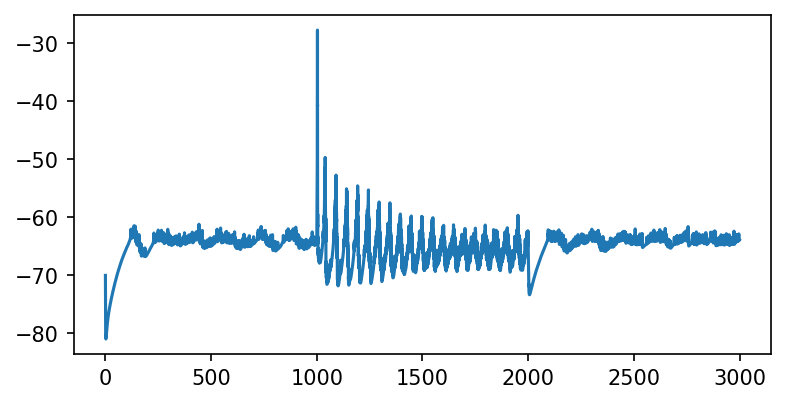

In [411]:
plt.figure(dpi=150, figsize=(6, 3))
plt.plot(obj_ntk.ts, vm)
plt.show()

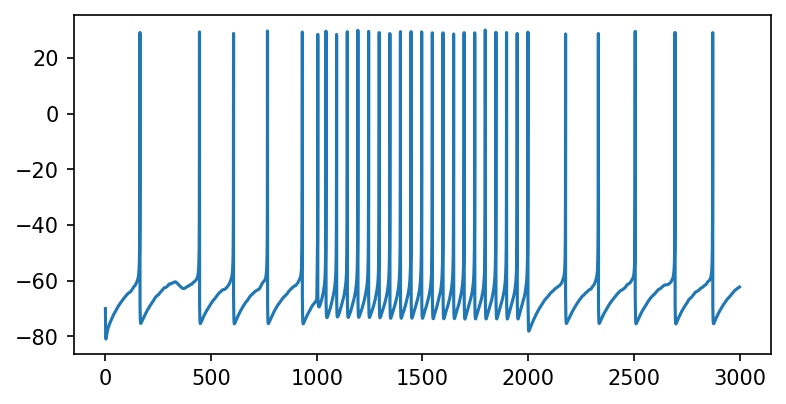

In [408]:
plt.figure(dpi=150, figsize=(6, 3))
plt.plot(obj_ntk.ts, obj_ntk.vs[:, 0])

(600001,)